In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Training an Intrusion Detection System with KDD99 Dataset**

In [43]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise
    
# print(path) 

# # This file is a CSV, just no CSV extension or headers
# # Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path, header=None)
df



,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


**Analyzing the Dataset**

In [45]:
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'label'
]

# display 5 rows
df[0:19289]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.00,0.00,0.11,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.00,0.00,0.05,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.00,0.00,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.00,0.00,0.03,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.00,0.00,0.02,0.00,0.0,0.0,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19284,0,tcp,smtp,SF,1089,492,0,0,0,0,...,242,0.95,0.03,0.02,0.01,0.0,0.0,0.0,0.0,normal.
19285,0,tcp,smtp,SF,1204,499,0,0,0,0,...,242,0.94,0.04,0.01,0.01,0.0,0.0,0.0,0.0,normal.
19286,0,udp,private,SF,28,0,0,1,0,0,...,1,0.01,0.05,0.01,0.00,0.0,0.0,0.0,0.0,teardrop.
19287,0,udp,private,SF,28,0,0,3,0,0,...,2,0.03,0.05,0.03,0.00,0.0,0.0,0.0,0.0,teardrop.


In [46]:
print("Read {} rows.".format(len(df)))
print('='*40)
print('The number of data points are:', df.shape[0])
print('='*40)
print('The number of features are:', df.shape[1])
print('='*40)
output = df['label'].values
labels = set(output)
print('The different type of output labels are:', labels)
print('='*125)
print('The number of different output labels are:', len(labels))

Read 494021 rows.
The number of data points are: 494021
The number of features are: 42
The different type of output labels are: {'teardrop.', 'imap.', 'warezclient.', 'pod.', 'neptune.', 'spy.', 'multihop.', 'ftp_write.', 'nmap.', 'back.', 'ipsweep.', 'land.', 'smurf.', 'satan.', 'portsweep.', 'phf.', 'warezmaster.', 'guess_passwd.', 'perl.', 'rootkit.', 'buffer_overflow.', 'normal.', 'loadmodule.'}
The number of different output labels are: 23


In [47]:
# Data Cleaning

# Checking for NULL values
print('Null values in dataset are',len(df[df.isnull().any(1)]))
print('='*40)

# Checkng for DUPLICATE values
df.drop_duplicates(keep='first', inplace = True)

# For now, just drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1) 

# stored the data into a pickle file so we can load through
# df.to_pickle('df.pkl')

print("Read {} rows.".format(len(df)))

C:\Users\dinh kha\AppData\Local\Temp\ipykernel_18208\2273894861.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  print('Null values in dataset are',len(df[df.isnull().any(1)]))


Null values in dataset are 0
Read 145586 rows.


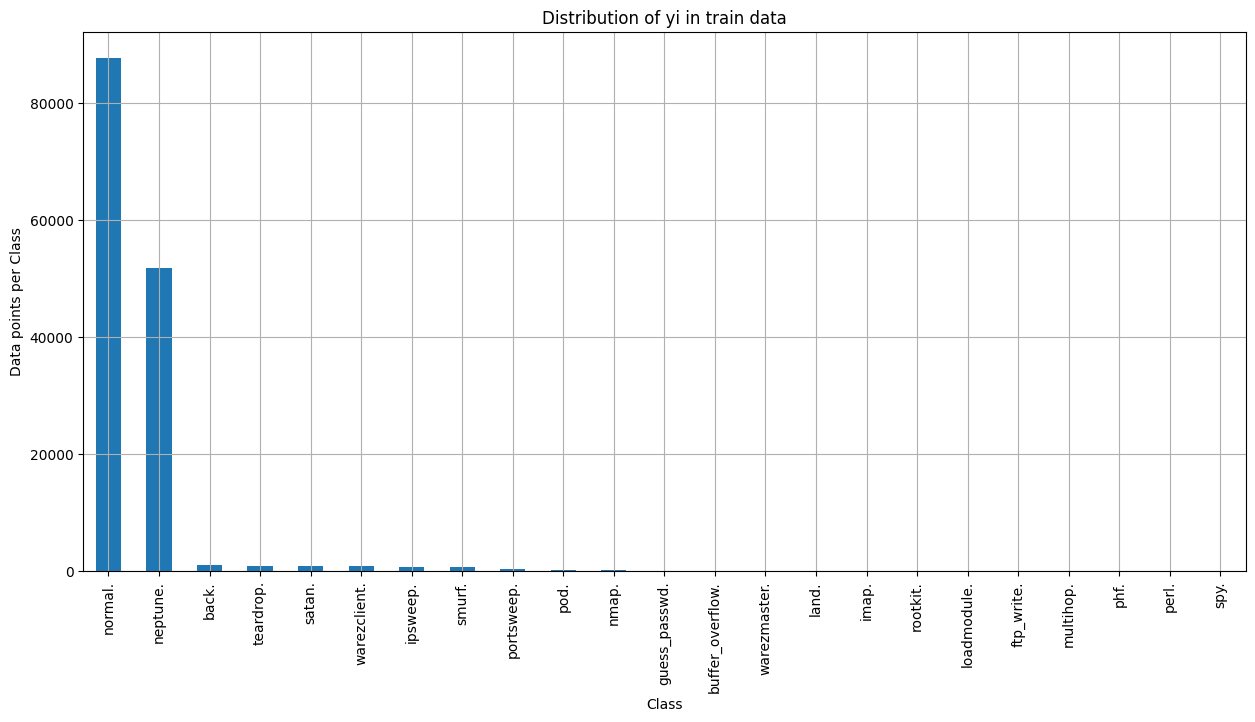

In [48]:
# Exploratory data analysis
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = df['label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [49]:
sorted_yi = np.argsort(-class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')
    
#df.groupby('outcome')['outcome'].count() #this could also be used if you want no-fromatted for above.

Number of data points in class normal. : 87832 ( 60.33 %)
Number of data points in class neptune. : 51820 ( 35.594 %)
Number of data points in class back. : 968 ( 0.665 %)
Number of data points in class teardrop. : 918 ( 0.631 %)
Number of data points in class satan. : 906 ( 0.622 %)
Number of data points in class warezclient. : 893 ( 0.613 %)
Number of data points in class ipsweep. : 651 ( 0.447 %)
Number of data points in class smurf. : 641 ( 0.44 %)
Number of data points in class portsweep. : 416 ( 0.286 %)
Number of data points in class pod. : 206 ( 0.141 %)
Number of data points in class nmap. : 158 ( 0.109 %)
Number of data points in class guess_passwd. : 53 ( 0.036 %)
Number of data points in class buffer_overflow. : 30 ( 0.021 %)
Number of data points in class warezmaster. : 20 ( 0.014 %)
Number of data points in class land. : 19 ( 0.013 %)
Number of data points in class imap. : 12 ( 0.008 %)
Number of data points in class rootkit. : 10 ( 0.007 %)
Number of data points in class

In [50]:
ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [51]:
# Analyze KDD-99

import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

analyze(df)


145586 rows
** duration:2495 (1%)
** protocol_type:[tcp:89.92%,udp:8.43%,icmp:1.65%]
** service:[http:42.62%,private:33.7%,smtp:6.68%,domain_u:3.73%,other:3.28%,ftp_data:3.15%,ecr_i:0.71%,eco_i:0.63%,ftp:0.55%,finger:0.46%,telnet:0.35%,urp_i:0.3%,auth:0.23%,ntp_u:0.2%,pop_3:0.14%,time:0.1%,csnet_ns:0.09%,remote_job:0.08%,gopher:0.08%,imap4:0.08%,discard:0.08%,iso_tsap:0.08%,systat:0.08%,domain:0.08%,echo:0.08%,rje:0.08%,shell:0.08%,whois:0.08%,sql_net:0.08%,courier:0.07%,printer:0.07%,nntp:0.07%,sunrpc:0.07%,netbios_ssn:0.07%,mtp:0.07%,klogin:0.07%,vmnet:0.07%,uucp_path:0.07%,supdup:0.07%,ssh:0.07%,nnsp:0.07%,uucp:0.07%,bgp:0.07%,hostnames:0.07%,daytime:0.07%,login:0.07%,link:0.07%,netbios_ns:0.07%,efs:0.07%,pop_2:0.07%,ldap:0.07%,http_443:0.07%,exec:0.07%,netbios_dgm:0.07%,kshell:0.07%,name:0.07%,ctf:0.07%,netstat:0.07%,Z39_50:0.06%,IRC:0.03%,urh_i:0.01%,X11:0.01%,tim_i:0.0%,pm_dump:0.0%,tftp_u:0.0%,red_i:0.0%]
** flag:[SF:60.07%,S0:29.04%,REJ:10.11%,RSTO:0.39%,RSTR:0.29%,S1:0.04%,SH

**Encode the feature vector**

In [53]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [54]:
# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net

C:\Users\dinh kha\AppData\Local\Temp\ipykernel_18208\2704301981.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\dinh kha\AppData\Local\Temp\ipykernel_18208\2704301981.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\dinh kha\AppData\Local\Temp\ipykernel_18208\2704301981.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004293,0.042595,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
1,-0.10785,-0.004261,-0.039036,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
2,-0.10785,-0.004263,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
3,-0.10785,-0.004272,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
4,-0.10785,-0.004273,-0.013613,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0


In [55]:
# Convert to numpy - Classification
x_columns = df.columns.drop('label')
x = df[x_columns].values
dummies = pd.get_dummies(df['label']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

In [56]:
df.groupby('label')['label'].count()

label
back.                 968
buffer_overflow.       30
ftp_write.              8
guess_passwd.          53
imap.                  12
ipsweep.              651
land.                  19
loadmodule.             9
multihop.               7
neptune.            51820
nmap.                 158
normal.             87832
perl.                   3
phf.                    4
pod.                  206
portsweep.            416
rootkit.               10
satan.                906
smurf.                641
spy.                    2
teardrop.             918
warezclient.          893
warezmaster.           20
Name: label, dtype: int64

**Train the Neural Network**

In [57]:
# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))


In [59]:
class EarlyStoppingByAccuracy:
    def __init__(self, monitor='val_acc', value=0.95, verbose=0):
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.best_model = None

    def on_epoch_end(self, epoch, logs={}):
        current_value = logs.get(self.monitor)
        if current_value is not None:
            if current_value >= self.value:
                if self.verbose:
                    print(f"Epoch {epoch + 1}: Early stopping (reached {self.monitor} >= {self.value})")
                self.model.stop_training = True
                self.best_model = clone(self.model)

In [61]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
CallBack_EarlyStopping = EarlyStoppingByAccuracy(monitor=['val_loss'], verbose=1)
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[CallBack_EarlyStopping],verbose=2,epochs=19)


AttributeError: 'EarlyStoppingByAccuracy' object has no attribute 'set_model'

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
CallBack_EarlyStopping = EarlyStopping(monitor=['val_loss'], min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[CallBack_EarlyStopping],verbose=2,epochs=19)

In [15]:
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('='*50)
model.summary()

Learning Rate - 
0.001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1210      
                                                                 
 dense_1 (Dense)             (None, 50)                550       
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
 dense_4 (Dense)             (None, 23)                46        
                                                                 
Total params: 2327 (9.09 KB)
Trainable params: 2327 (9.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
import seaborn as sns
import datetime as dt

def confusion_matrix_func(y_test, y_test_pred):
    
    '''
    This function computes the confusion matrix using Predicted and Actual values and plots a confusion matrix heatmap
    '''
    C = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(C)
    labels = ['back', 'butter_overflow', 'loadmodule', 'guess_passwd', 'imap', 'ipsweep', 'warezmaster', 'rootkit', 
'multihop', 'neptune', 'nmap', 'normal', 'phf', 'perl', 'pod', 'portsweep', 'ftp_write', 'satan', 'smurf', 'teardrop', 'warezclient', 'land']
    plt.figure(figsize=(20,15))
    sns.set(font_scale=1.4)
    sns.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    
    plt.show()

# calculate roc curve
from sklearn.metrics import *
#fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, pred)
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    pred = lb.transform(pred)
    return roc_auc_score(y_test, pred, average=average)

In [17]:
print('Train data')
print(x_train.shape)
print(y_train.shape)
print('='*20)
print('Test data')
print(x_test.shape)
print(y_test.shape)
print('='*20)

# Measure accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
print('Predicting on the test data:')
start = dt.datetime.now()
escore = model.evaluate(x_test, y_test, batch_size=32)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)

vscore = metrics.accuracy_score(y_eval, pred)

rscore = recall_score(y_eval, pred, average='weighted')

ascore = precision_score(y_eval, pred, average='weighted')

f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

roc_auc_socre = multiclass_roc_auc_score(y_eval, pred)


print('Completed')
print('Time taken:',dt.datetime.now()-start)
print('='*50)
print("Validation score: {}".format(vscore))
print('='*50)
print("Evaluation score: {}".format(escore))
print('='*50)
print("Recall score: {}".format(rscore))
print('='*50)
print("Precision score: {}".format(ascore))
print('='*50)
print("F1 score: {}".format(f1score))
print('='*50)
print("ROC-AUC score: {}".format(roc_auc_socre))


Train data
(109189, 120)
(109189, 23)
Test data
(36397, 120)
(36397, 23)
Predicting on the test data:
1138/1138 [==============================] - 1s 1ms/step
Completed
Time taken: 0:00:02.988188
Validation score: 0.9914828145176801
Evaluation score: 0.059068601578474045
Recall score: 0.9914828145176801
Precision score: 0.9886631100844624
F1 score: 0.9897764222542167
ROC-AUC score: 0.6949020132019295


c:\Users\dinh kha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


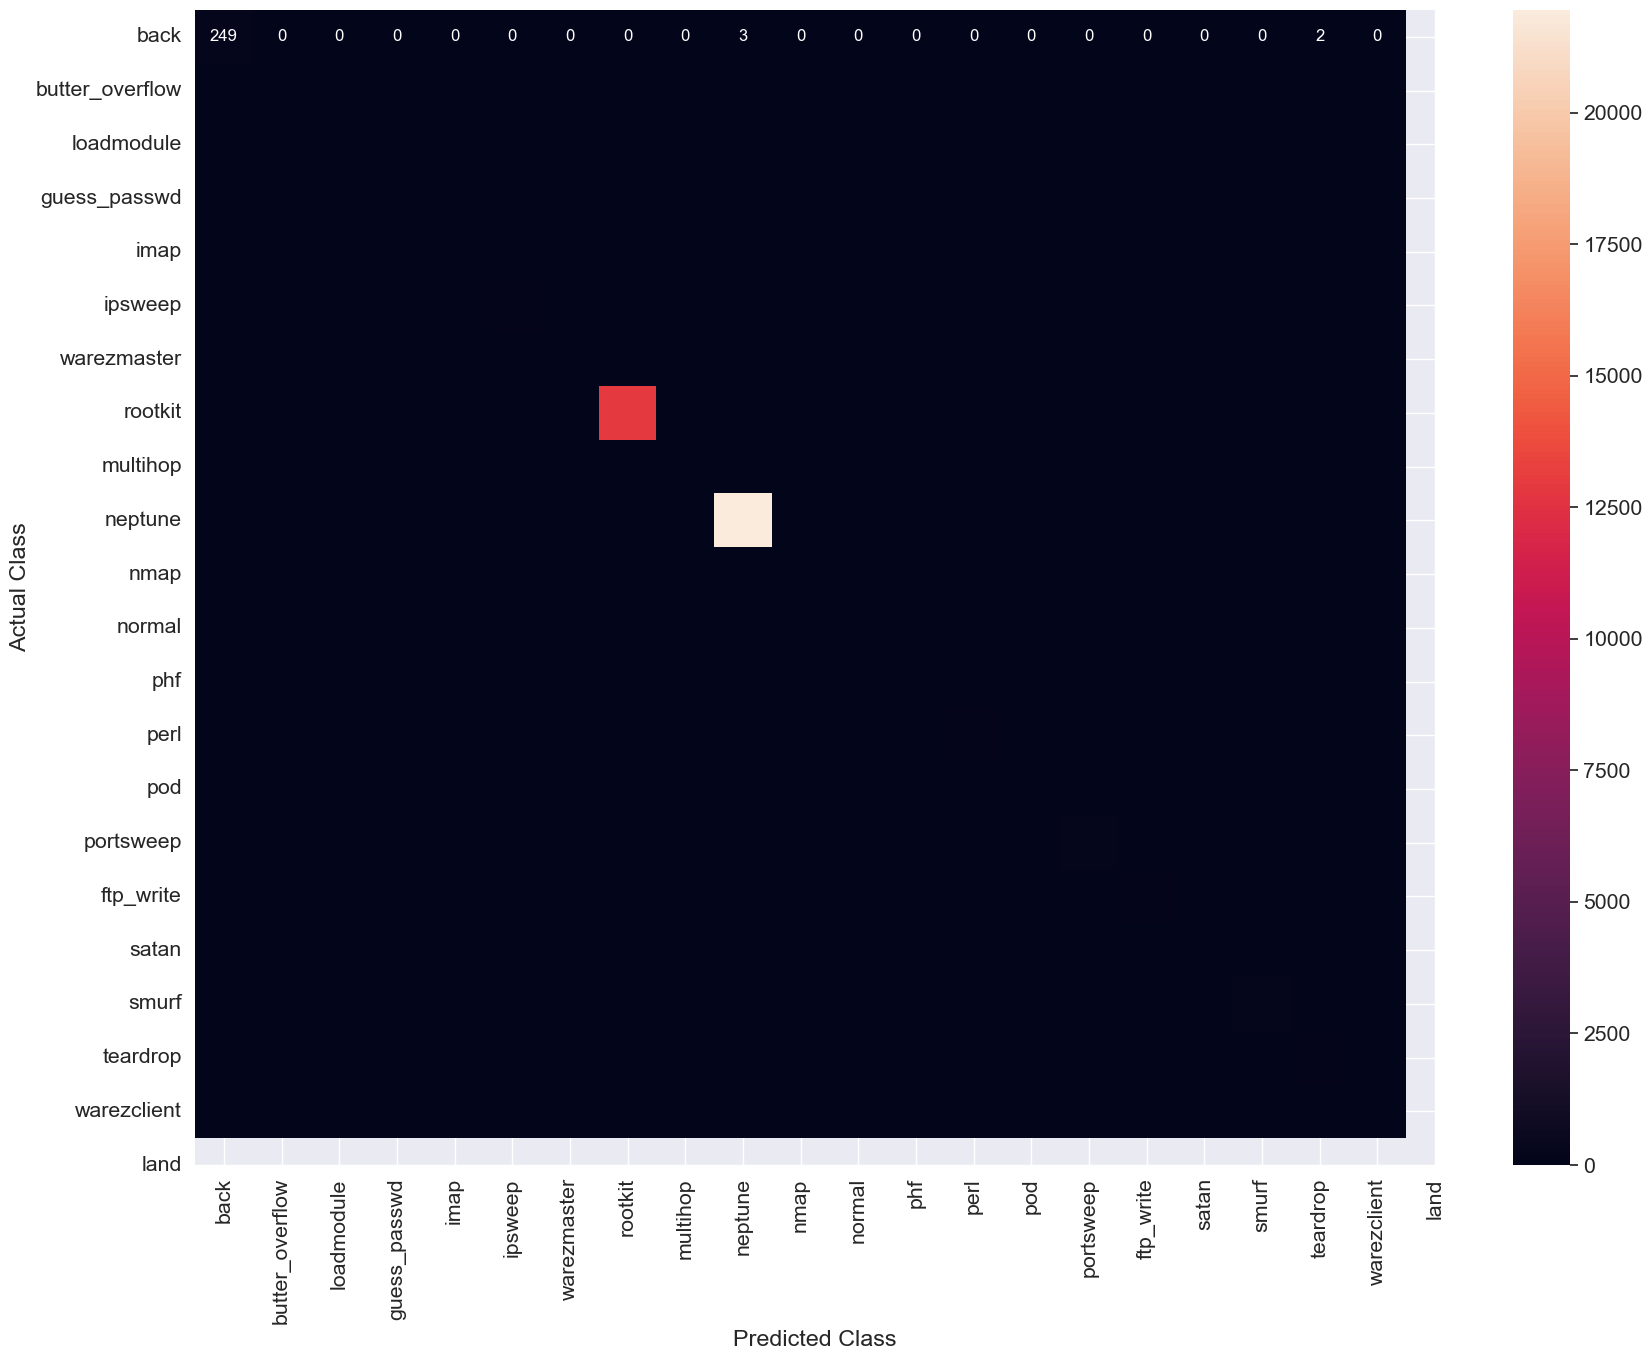

In [21]:
confusion_matrix_func(y_eval, pred)
# cm=confusion_matrix(y_eval, pred)
# ConfusionMatrixDisplay(cm).plot()

SVM MODEL


In [1]:

from sklearn.svm import SVC, LinearSVC
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'linearSVC'])
    c = trial.suggest_float('c', 0.02, 1.0, step=0.02)
    if kernel in ['linear', 'rbf']:
        classifier_obj = SVC(kernel=kernel, C=c).fit(x_train, y_train)
    elif kernel == 'linearSVC':
        classifier_obj = LinearSVC(C=c).fit(x_train, y_train)
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
        classifier_obj = SVC(kernel=kernel, C=c, degree=degree).fit(x_train, y_train)
        
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [3]:
import optuna
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=30)
print(study_svm.best_trial)

ModuleNotFoundError: No module named 'optuna'